In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import calpred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import os
import subprocess
from scipy import stats
import matplotlib

matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

Simulation example of how different disease architecture and disease prevalence impact transferability of disease risk prediction.

1. Genetic architecture (genetic value) (see gxe_mode_simulation)
2. Prevalence.

Build API for disease trait prediction (plotting / fitting / predicting, etc.)

In [2]:
def format_df(prs, y, fit_exog):
    df = {"PRS": [], "E": [], "y": []}
    for i in range(2):
        df["PRS"].extend(prs[:, i])
        df["E"].extend([i] * len(prs))
        df["y"].extend(y[:, i])
    df = pd.DataFrame(df)
    df["PRSxE"] = df["PRS"] * df["E"]

    exog = sm.add_constant(df[fit_exog])

    model = sm.Probit(endog=df["y"], exog=exog).fit(disp=0)
    # Logit and Probit have similar results
    # model = sm.Logit(endog=df["y"], exog=exog).fit(disp=0)

    df["prob"] = model.predict(exog)
    return df


def plot_df(df, figsize=(7.5, 3)):

    fig, axes = plt.subplots(
        figsize=figsize, dpi=150, ncols=3, sharex=True, sharey=True
    )

    for i, name in zip([0, 1, 2], ["Overall", "E=1", "E=2"]):
        ax = axes[i]
        if i == 0:
            sub_df = df
        elif i in [1, 2]:
            e = i - 1
            sub_df = df[df["E"] == e].reset_index(drop=True)
        else:
            raise NotImplementedError

        calpred.plot_prob_calibration(
            prob=sub_df["prob"], y=sub_df["y"], color="blue", ax=ax
        )

        ax.set_title(name)
        ax.set_xlabel("Predicted")
    axes[0].set_ylabel("Observed")
    fig.tight_layout()
    return fig, axes

# Scenario 1: different genetic architecture (genetic correlation < 1)

In [3]:
np.random.seed(1234)

rep = 0

ymat, prsmat, gmat, emat, betamat, betaprsmat = calpred.simulate_gxe(
    scenario=1, hsq=0.5, rg=0.5, n_rep=10
)

prevalence = 0.1
threshold = -stats.norm.ppf(prevalence)
ymat = (ymat > threshold).astype(int)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.10it/s]


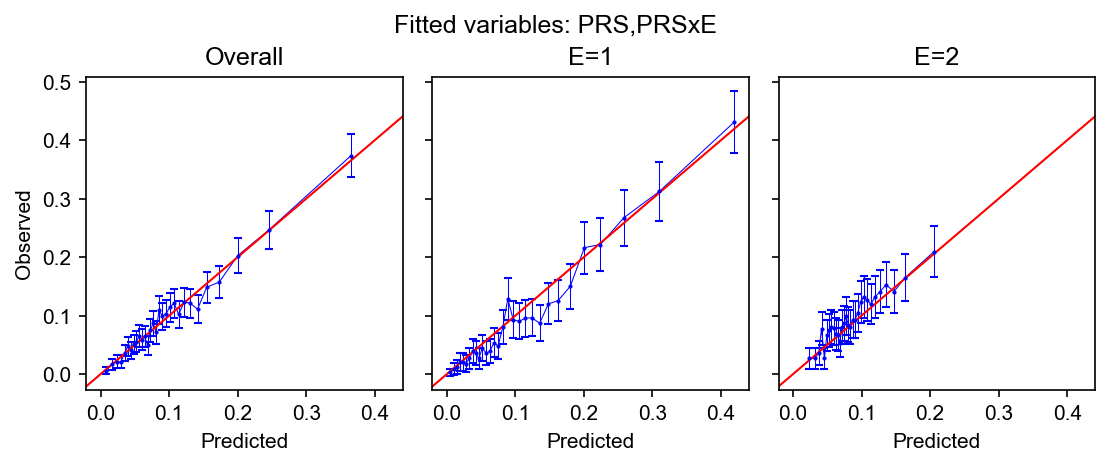

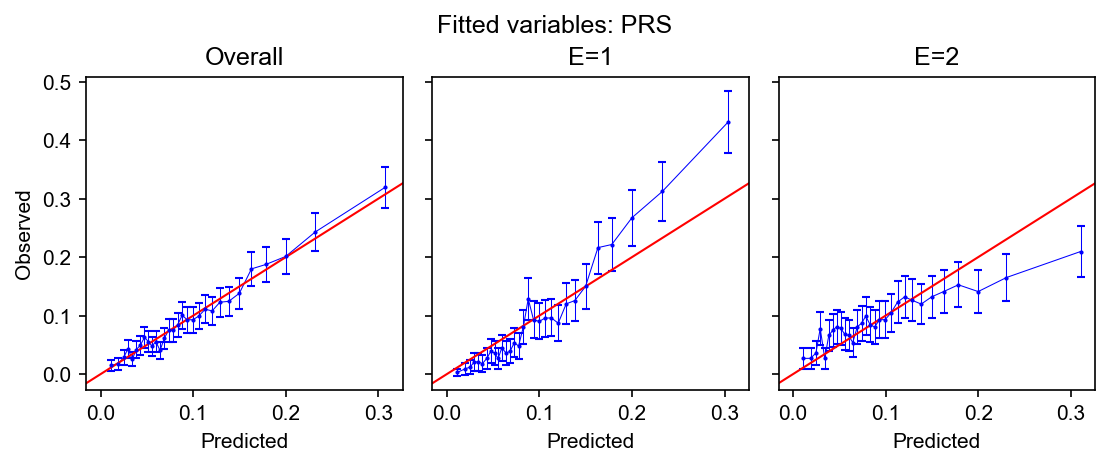

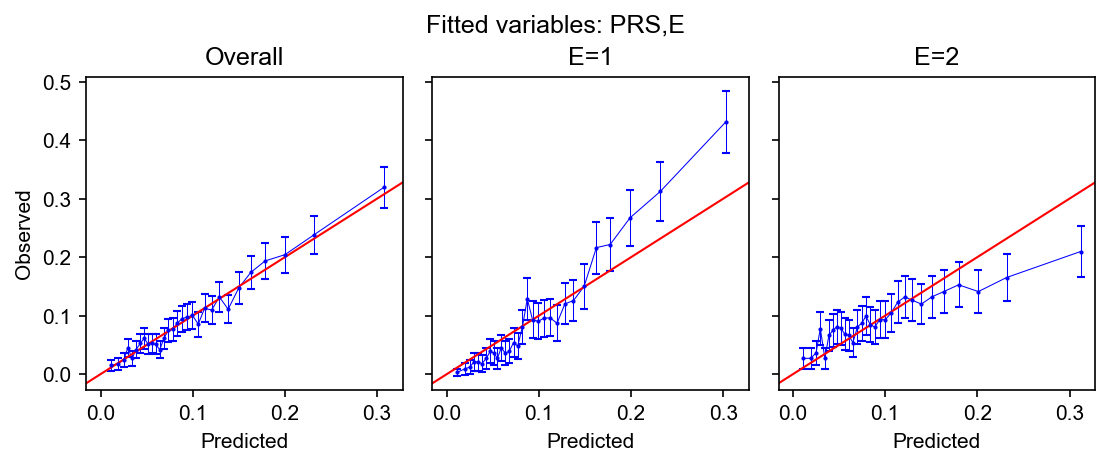

In [4]:
for exog in [["PRS", "PRSxE"], ["PRS"], ["PRS", "E"]]:
    df = format_df(prs, y, fit_exog=exog)
    fig, axes = plot_df(df)
    fig.suptitle("Fitted variables: " + ",".join(exog), y=1.02)

# Scenario 2: different genetic architecture (different heritability)

In [5]:
np.random.seed(1234)

ymat, prsmat, gmat, emat, beta, betaprs = calpred.simulate_gxe(
    scenario=2, hsq1=0.5, hsq2=0.1
)

prevalence = 0.1
threshold = -stats.norm.ppf(prevalence)
ymat = (ymat > threshold).astype(int)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 248.16it/s]


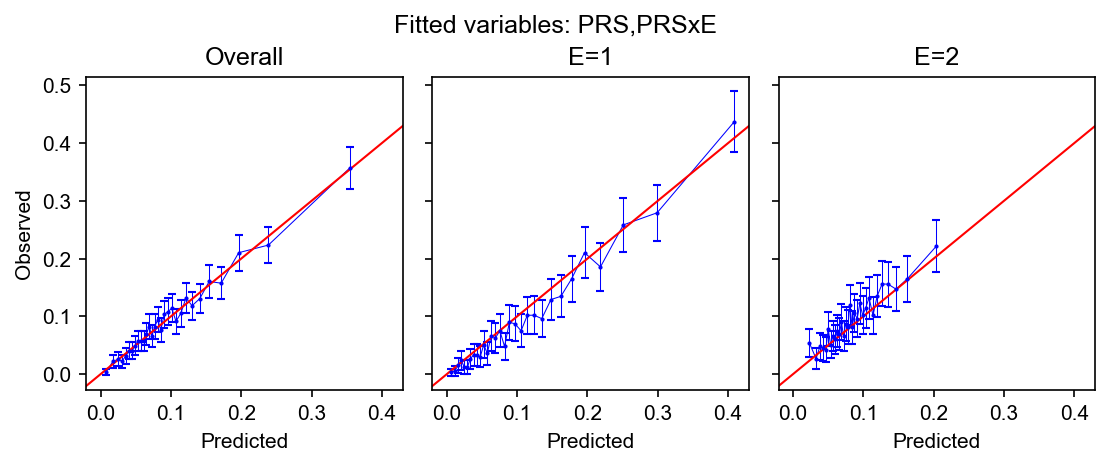

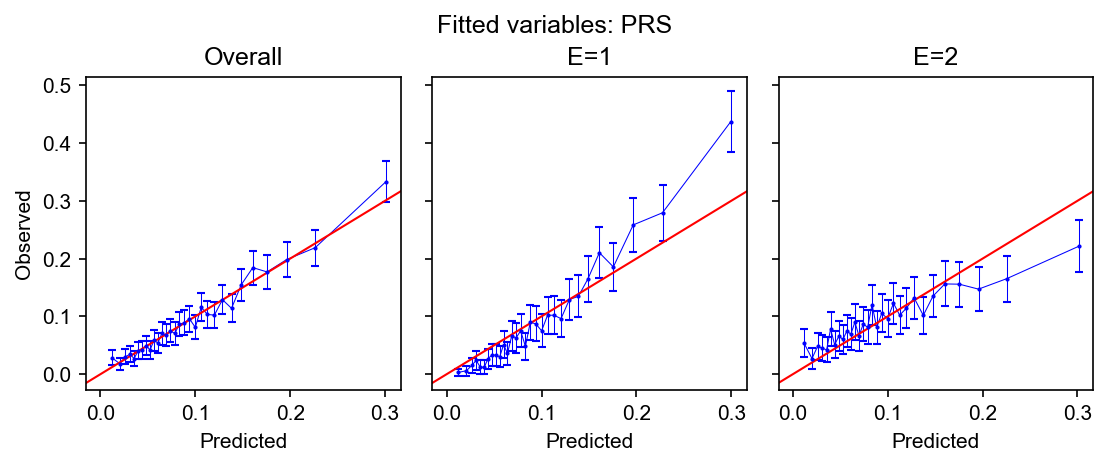

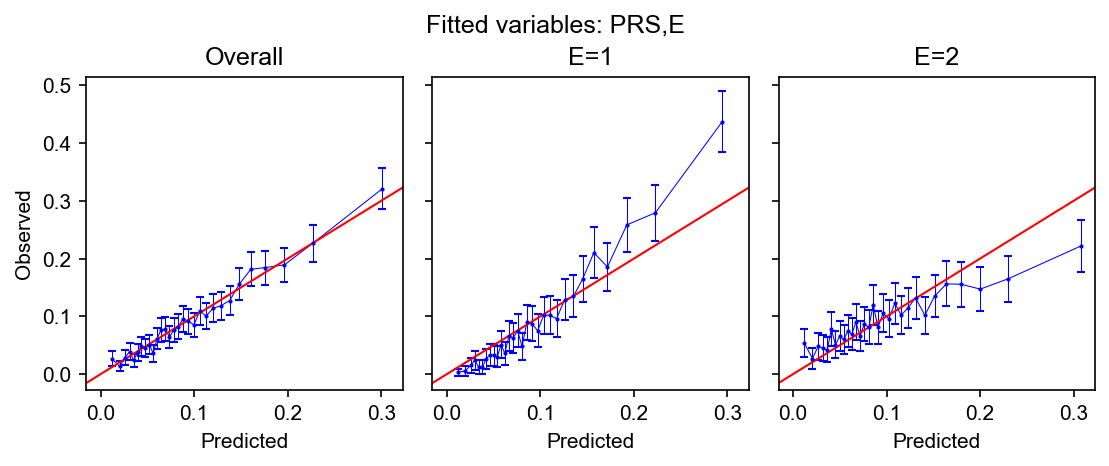

In [6]:
for exog in [["PRS", "PRSxE"], ["PRS"], ["PRS", "E"]]:
    df = format_df(prs, y, fit_exog=exog)
    fig, axes = plot_df(df)
    fig.suptitle("Fitted variables: " + ",".join(exog), y=1.02)

# Scenario 3: same genetic architecture / different disease prevalence

In [7]:
np.random.seed(1234)

rep = 0

ymat, prsmat, gmat, emat, betamat, betaprsmat = calpred.simulate_gxe(
    scenario=1, hsq=0.5, rg=1.0, n_rep=10
)
prevalence1 = 0.1
prevalence2 = 0.5
threshold1 = -stats.norm.ppf(prevalence1)
threshold2 = -stats.norm.ppf(prevalence2)

ymat[:, 0, :] = (ymat[:, 0, :] > threshold1).astype(int)
ymat[:, 1, :] = (ymat[:, 1, :] > threshold2).astype(int)

y, prs, g = ymat[:, :, rep], prsmat[:, :, rep], gmat[:, :, rep]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 428.91it/s]


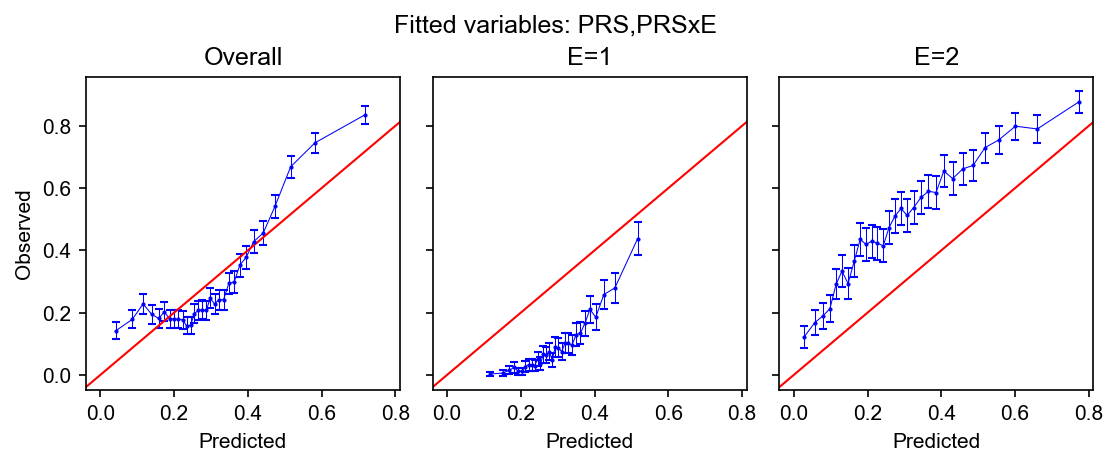

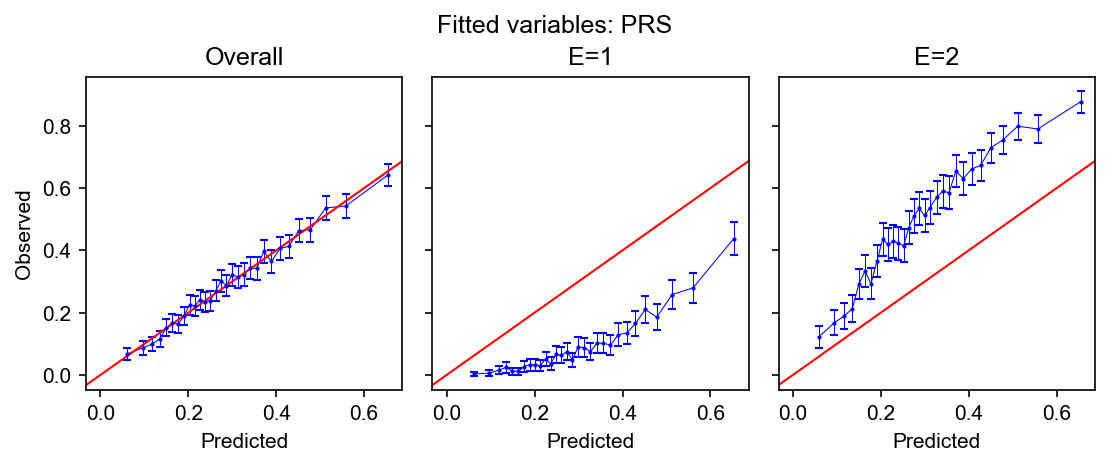

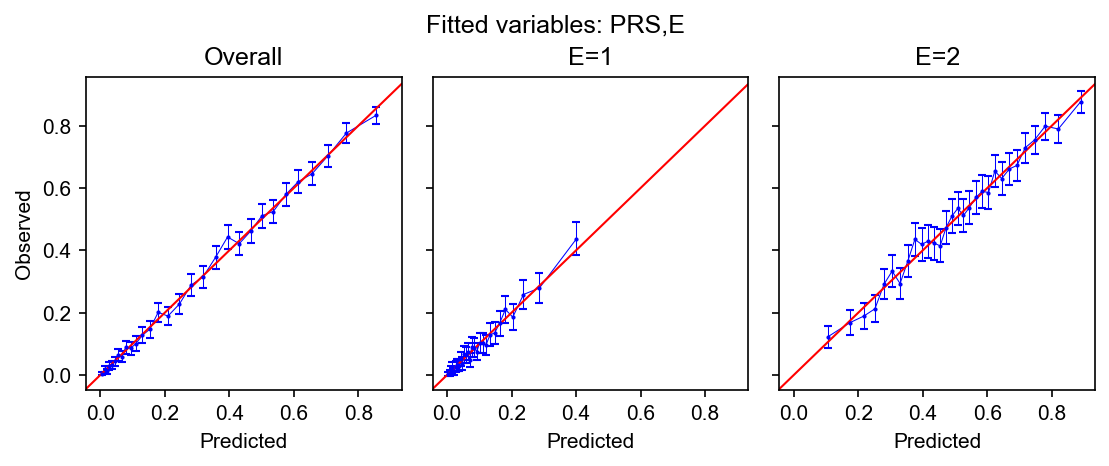

In [8]:
for exog in [["PRS", "PRSxE"], ["PRS"], ["PRS", "E"]]:
    df = format_df(prs, y, fit_exog=exog)
    fig, axes = plot_df(df)
    fig.suptitle("Fitted variables: " + ",".join(exog), y=1.02)